# Compressive Sensing

Working from compressive sensing into. PDF in this dir.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import cvxpy as cvx
from l1 import l1
%matplotlib inline

# Fig2 Example Sparse Signal

Using notation from the text.

Text(0.5,1,'Sample in Time Domain')

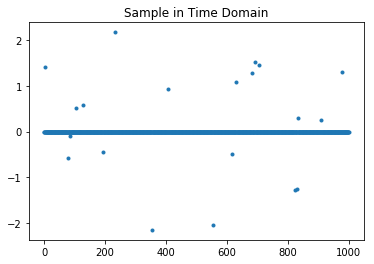

In [2]:
# Create sparse (in time domain) signal
S = 20
f = np.concatenate((np.zeros(1000 - S), np.random.normal(size=S)))
np.random.shuffle(f)
plt.plot(f, '.')
plt.title('Sample in Time Domain')

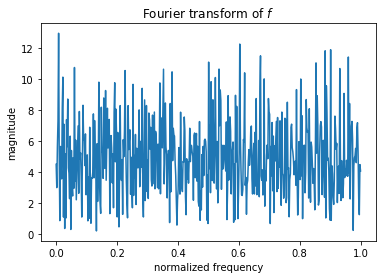

In [3]:
# Transform into freq domain
F = np.fft.fftshift(np.fft.fft(f))

half_n = int(len(F) / 2)
freq_ax = np.linspace(0, 1, half_n)
plt.plot(freq_ax, np.abs(F[half_n:]))
plt.ylabel('magnitude')
plt.xlabel('normalized frequency')
plt.title('Fourier transform of $f$');

In [4]:
# Check the matrix form
W = sp.linalg.dft(len(f))
W.dot(f)[:3], np.fft.fft(f)[:3]

(array([ 4.50717096+0.j        ,  2.78021061+1.13566163j,
        -1.86258632-5.30863042j]),
 array([ 4.50717096+0.j        ,  2.78021061+1.13566163j,
        -1.86258632-5.30863042j]))

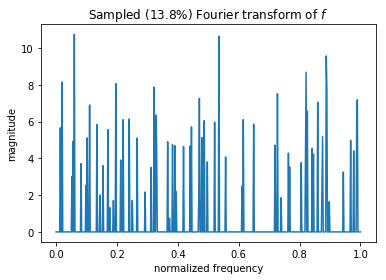

In [5]:
# Randomly subsample the fourier space
M = int(1*S*np.log(len(f)))

zeros_idx = np.arange(len(F))
np.random.shuffle(zeros_idx)
zeros_idx = zeros_idx[:-M]

sampled_F = np.copy(F)
sampled_F[zeros_idx] = 0

half_n = int(len(sampled_F) / 2)
freq_ax = np.linspace(0, 1, half_n)
plt.plot(freq_ax, np.abs(sampled_F[half_n:]))
plt.ylabel('magnitude')
plt.xlabel('normalized frequency')
plt.title('Sampled ({}%) Fourier transform of $f$'.format(100*M/len(F)));

/Users/spencer/Documents/Personal/learn-python/compressive_sampling/venv/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


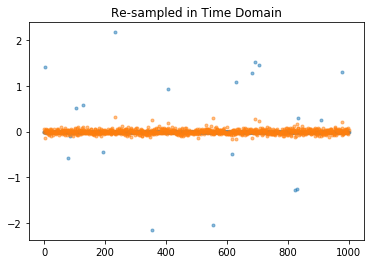

In [6]:
sampled_f = np.fft.ifft(sampled_F)

plt.plot(f, '.', alpha=0.5)
plt.plot(sampled_f, '.', alpha=0.5)
plt.title('Re-sampled in Time Domain');

862

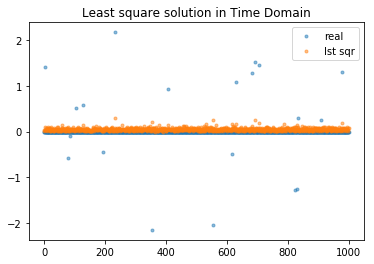

In [7]:
# Try solving inverse prob
# F = W*f
# Try least square solution:
W = sp.linalg.dft(len(f))
lst_sqr, _, rank, _ = np.linalg.lstsq(W[:, ~zeros_idx].T, sampled_F[~zeros_idx])

plt.plot(f, '.', alpha=0.5)
plt.plot(np.abs(lst_sqr), '.', alpha=0.5)
plt.legend(['real', 'lst sqr'])
plt.title('Least square solution in Time Domain')
rank

# Take 2

So the above didn't work out so hot.... I got a little confused and didn't see consistent least squares results.

I'm going to follow this example: https://www.codeproject.com/Articles/852910/Compressed-Sensing-Intro-Tutorial-w-Matlab

Text(0.5,1,'Recomputed l1 signal')

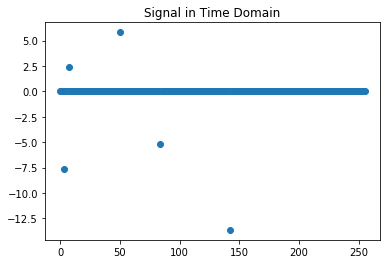

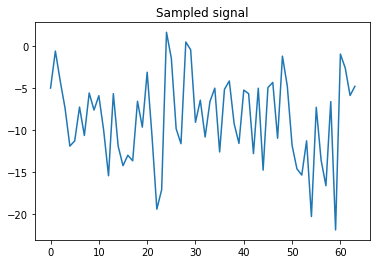

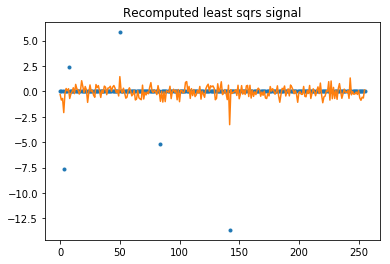

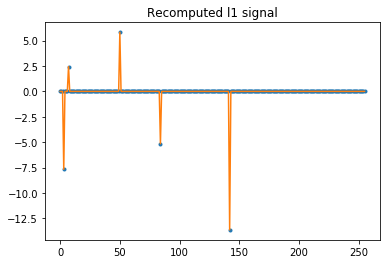

In [8]:
N = 256 # Signal len
S = 5 # number of non-zero bits
M = int(N/4) # Num of measurements

# Signal
f = np.concatenate((np.zeros(N - S), np.random.normal(scale=5, size=S)))
np.random.shuffle(f)

plt.figure()
plt.plot(f, 'o')
plt.title('Signal in Time Domain')

# Sample
A = np.random.rand(M, N)
F = A.dot(f)

plt.figure()
plt.plot(F)
plt.title('Sampled signal')

# Least Squares optimization
f_lstsq, _, rank, _ = np.linalg.lstsq(A, F)
plt.figure()
plt.plot(f, '.')
plt.plot(f_lstsq)
plt.title('Recomputed least sqrs signal')

# Reconstruct
# See https://github.com/cvxopt/cvxopt/issues/43
x = cvx.Variable(N)
obj = cvx.Minimize(cvx.norm(x, 1))
const = [A * x == F]
prob = cvx.Problem(obj, const)
result = prob.solve()
f_l1 = x.value

plt.figure()
plt.plot(f, '.')
plt.plot(f_l1)
plt.title('Recomputed l1 signal')

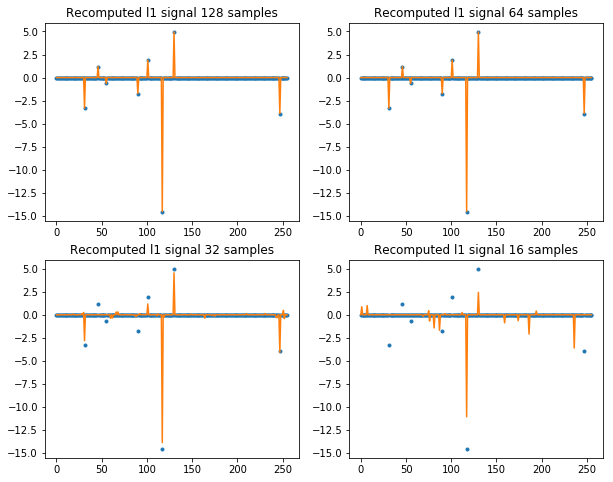

In [9]:
def compressed_time(signal, n_samples, ax):
    # Sampling
    A = np.random.rand(n_samples, len(signal))
    X = A.dot(signal)
    
    # Solve norm
    x = cvx.Variable(len(signal))
    obj = cvx.Minimize(cvx.norm(x, 1))
    const = [A * x == X]
    prob = cvx.Problem(obj, const)
    prob.solve()

    ax.plot(signal, '.')
    ax.plot(x.value)
    ax.set_title('Recomputed l1 signal {} samples'.format(n_samples))
    
# Generate signal
signal = np.concatenate((np.zeros(256 - 8), np.random.normal(scale=5, size=8)))
np.random.shuffle(signal)

_, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = np.ravel(axes)
for i, n_samples in enumerate([128, 64, 32, 16]):
    compressed_time(signal, n_samples, axes[i])

# Sparse in Freq Domain

Example 2 from https://www.codeproject.com/Articles/852910/Compressed-Sensing-Intro-Tutorial-w-Matlab

/Users/spencer/Documents/Personal/learn-python/compressive_sampling/venv/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  return new.astype(intype)


ValueError: Incompatible dimensions (64, 1) (256, 1)

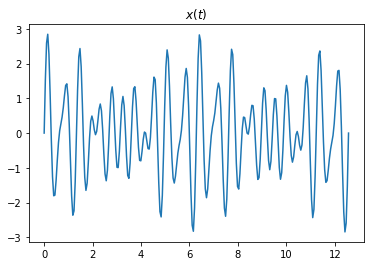

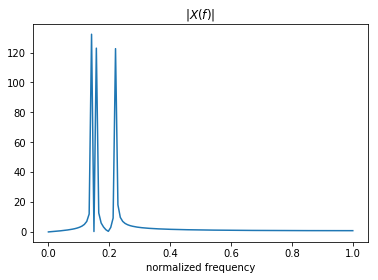

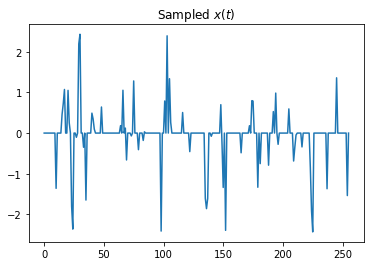

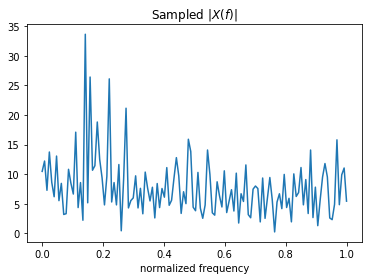

In [95]:
# Signal (composed of 3 random freq)
freq = np.linspace(0, 4*np.pi, 256).reshape(-1, 1)
rand_freq = freq.dot(np.random.randint(1, 64, size=(1, 3)))
x = np.sum(np.sin(rand_freq), axis=1)

plt.plot(freq, x)
plt.title('$x(t)$')

# Fourier 
X = np.fft.fft(x)
plt.figure()
subsampled_X = np.abs(np.hsplit(np.fft.fftshift(X), 2)[1])
freq = np.linspace(0, 1, len(subsampled_X))
plt.plot(freq, subsampled_X)
plt.title('$|X(f)|$')
plt.xlabel('normalized frequency')

# Sparse Sampling in Time Domain
A = np.concatenate((np.zeros(len(x) - 64), np.ones(64)))
np.random.shuffle(A)
A_freq = sp.linalg.dft(len(x))[A == 1, :]
y = np.multiply(A, x)

plt.figure()
plt.plot(y)
plt.title('Sampled $x(t)$')

# Sampled Freq
Y = np.fft.fft(y)
plt.figure()
subsampled_Y = np.abs(np.hsplit(np.fft.fftshift(Y), 2)[1])
freq = np.linspace(0, 1, len(subsampled_Y))
plt.plot(freq, subsampled_Y)
plt.title('Sampled $|X(f)|$')
plt.xlabel('normalized frequency')

# Reconstruction
X_reconstruct = cvx.Variable(len(x))
obj = cvx.Minimize(cvx.norm(X_reconstruct, 1))
const = [A_freq * X_reconstruct == Y]
prob = cvx.Problem(obj, const)
prob.solve()

# Ok Now With Images

Images are sparse in the fourier domain....

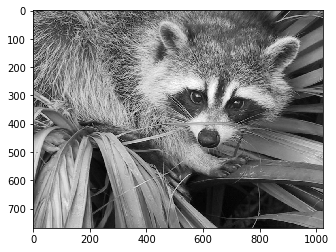

In [11]:
# Load sample image and convert to grayscale
im = sp.misc.face()
im = im.dot([0.2126, 0.7152, 0.0722])
plt.imshow(im, cmap='gray')

In [12]:
im.shape

(768, 1024)

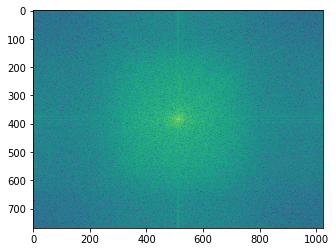

In [13]:
I = np.fft.fft2(im)
plt.imshow(np.log(np.fft.fftshift(abs(I))))